## Step 2: Training a simple model

In [1]:
import os
import time
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import torch
import torch.nn as nn

from wholeslidedata.interoperability.detectron2.iterator import WholeSlideDetectron2Iterator
from wholeslidedata.interoperability.detectron2.trainer import WholeSlideDectectron2Trainer
from wholeslidedata.interoperability.detectron2.predictor import Detectron2DetectionPredictor
from wholeslidedata.iterators import create_batch_iterator
from utils.vis import plot_boxes, FocalLoss

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model

from utils.loss import MyFocalROIHeads 

Setting up the training configuration and parameters (can also be defined in a separate yaml file).

In [2]:
user_config = {
    'wholeslidedata': {
        'default': {
            'yaml_source': "./configs/training_sample.yml",
            "seed": 42,
            "image_backend": "asap",
            'labels': {
                "ROI": 0,
                "lymphocytes": 1,
                "monocytes": 2
            },
        
            
            'batch_shape': {
                'batch_size': 128,
                'spacing': 0.25,
                'shape': [224,224,3],#[128,128,3],
                'y_shape': [500, 6],
            },
            
            
            
            "annotation_parser": {
                "sample_label_names": ['roi'],
            },
            
            'point_sampler_name': "RandomPointSampler",
            'point_sampler': {
                "buffer": {'spacing': "${batch_shape.spacing}", 'value': -64},
            },
            
            'patch_label_sampler_name': 'DetectionPatchLabelSampler',
            'patch_label_sampler': {
                "max_number_objects": 500,
                "detection_labels": ['lymphocytes','monocytes'],
                    
            },
            
        }
    }
}

Creating the batch generator.

In [3]:
training_batch_generator = create_batch_iterator(
    user_config=user_config,
#     user_config=r'./configs/training_config.yml',
    mode='training',
    cpus=4,
    iterator_class=WholeSlideDetectron2Iterator,
)
# validation_batch_generator = create_batch_iterator(
#     user_config=user_config,
#     mode='validation',
#     cpus=1,
#     iterator_class=WholeSlideDetectron2Iterator,
# )


Visualizing a sample batch.

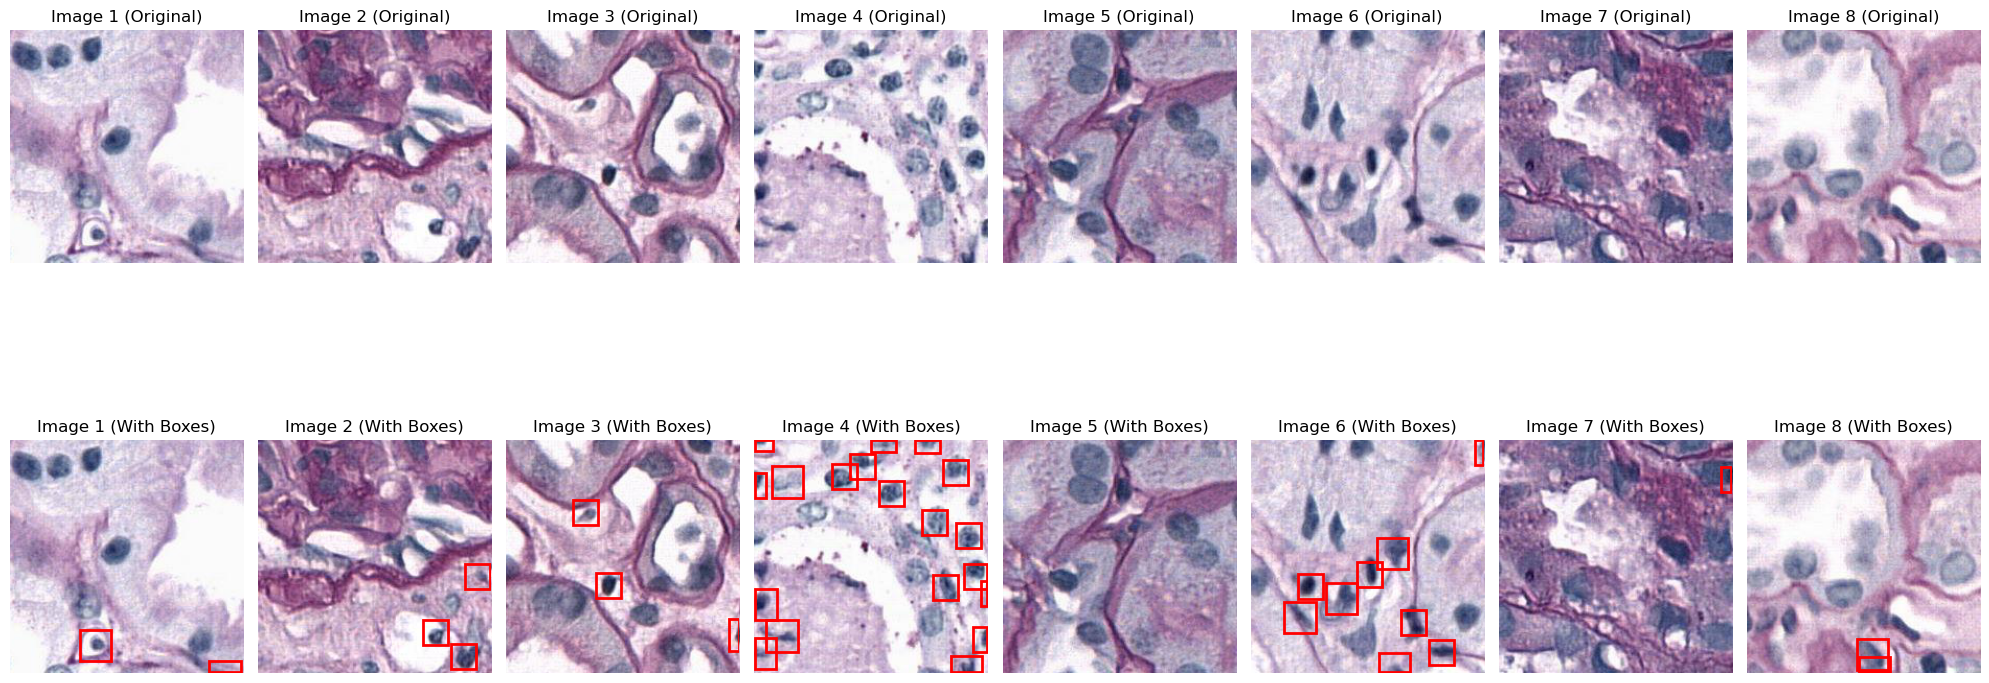

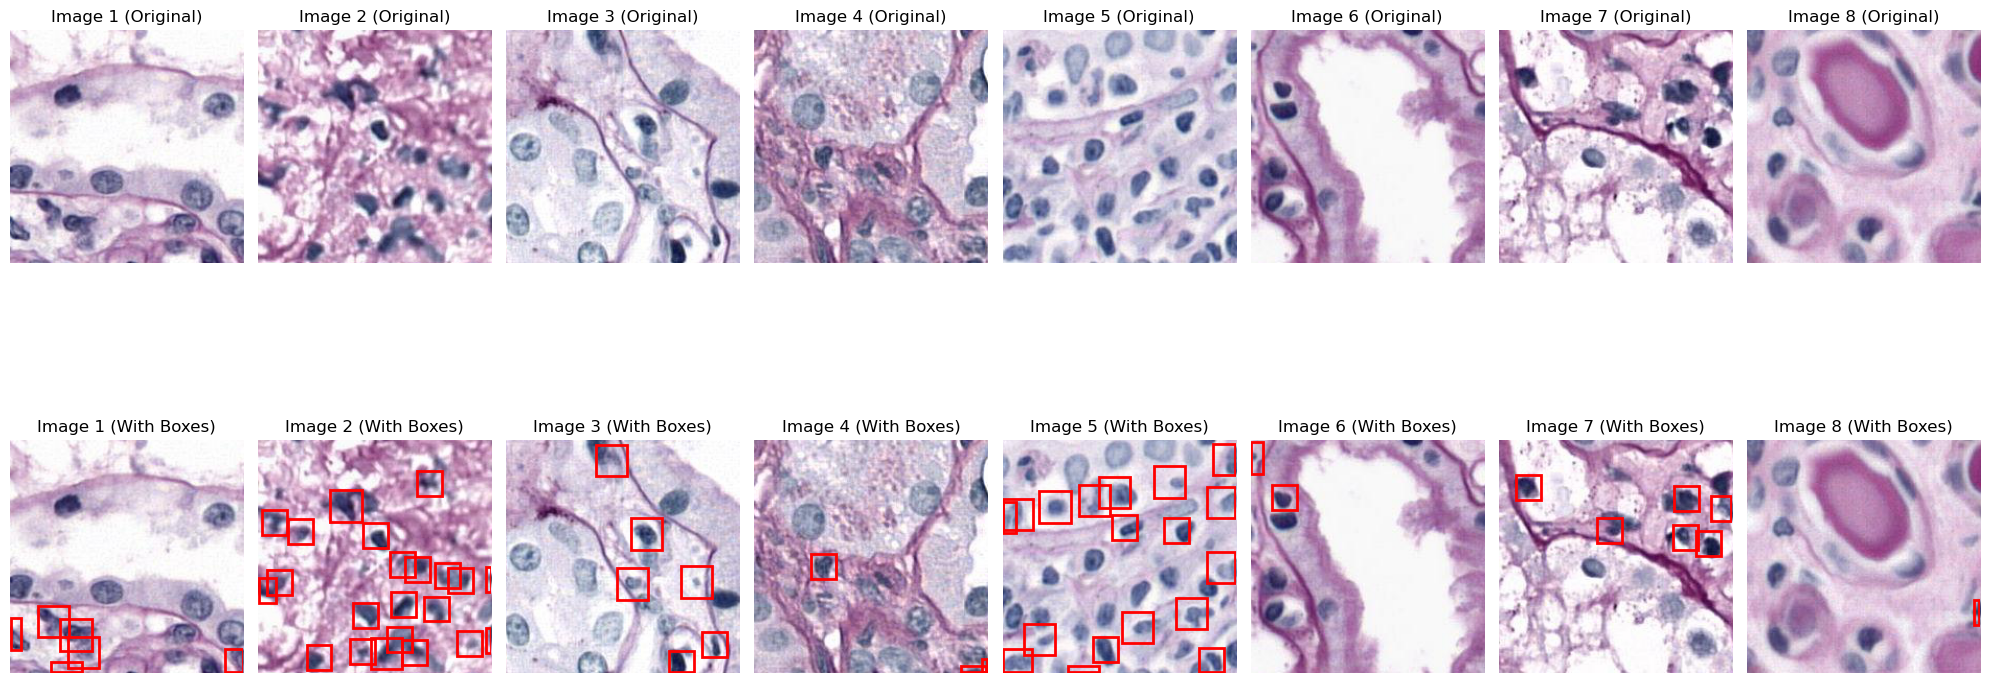

In [4]:
batch_dicts = next(training_batch_generator)

import matplotlib.pyplot as plt
import numpy as np

for _ in range(2):
    batch_dicts = next(training_batch_generator)  # トレーニング用バッチを取得
    fig, ax = plt.subplots(2, 8, figsize=(20, 10))  # 2行8列のサブプロット (元画像とボックス画像)

    for i in range(8):
        # 画像データ取得
        patch = batch_dicts[i]['image'].cpu().detach().numpy().transpose(1, 2, 0).astype('uint8')
        
        # バウンディングボックスとクラス取得
        _boxes = batch_dicts[i]['instances'].gt_boxes.tensor.cpu().detach().numpy()
        _class = batch_dicts[i]['instances'].gt_classes.cpu().detach().numpy()

        # バウンディングボックスの整形
        boxes = np.ones((len(_boxes), 6))
        boxes[..., :4] = _boxes
        max_width, max_height = batch_dicts[i]['instances'].image_size
        
        # --- 1行目: 元画像表示 ---
        ax[0, i].imshow(patch)
        ax[0, i].axis('off')  # 軸を非表示
        ax[0, i].set_title(f"Image {i+1} (Original)")

        # --- 2行目: ボックス付き画像表示 ---
        ax[1, i].imshow(patch)
        plot_boxes(boxes, max_width=max_width, max_height=max_height, axes=ax[1, i])  # ボックスを描画
        ax[1, i].axis('off')  # 軸を非表示
        ax[1, i].set_title(f"Image {i+1} (With Boxes)")

    plt.tight_layout()
    plt.show()


Creating the output folder for saving the model and results.

In [5]:
output_folder = Path('./outputs')
if not(os.path.isdir(output_folder)): os.mkdir (output_folder) 
cpus = 4

# Train the model

In [6]:
from detectron2.modeling.roi_heads.box_head import ROI_BOX_HEAD_REGISTRY, FastRCNNConvFCHead

@ROI_BOX_HEAD_REGISTRY.register()
class MyDropoutFastRCNNConvFCHead(FastRCNNConvFCHead):
    def __init__(self, cfg, input_shape):
        super().__init__(cfg, input_shape)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = super().forward(x)
        x = self.dropout(x)
        return x


In [ ]:
cfg = get_cfg()
# using faster rcnn architecture
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
)

#faster_rcnn_X_101_32x8d_FPN_3x.yaml
cfg.DATASETS.TRAIN = ("detection_dataset2",)
cfg.DATASETS.TEST = () 
cfg.TEST.EVAL_PERIOD = 20  # 200イテレーション毎に評価を実施（例）
cfg.DATALOADER.NUM_WORKERS = 4

cfg.MODEL.ROI_BOX_HEAD.NAME = "MyDropoutFastRCNNConvFCHead"
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[16, 24, 32]]
#cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[1.0]]
cfg.MODEL.ROI_HEADS.NAME = "MyFocalROIHeads"

cfg.SOLVER.IMS_PER_BATCH = 256
cfg.SOLVER.BASE_LR = 0.03  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000  # 2000 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.SOLVER.STEPS = (500, 750)
cfg.SOLVER.WARMUP_ITERS = 100
cfg.SOLVER.WARMUP_FACTOR = 1.0/1000 
cfg.SOLVER.GAMMA = 0.5
cfg.SOLVER.CHECKPOINT_PERIOD = 200
cfg.SOLVER.WEIGHT_DECAY = 0.005


cfg.INPUT.RANDOM_FLIP = "horizontal, vertical"  # "horizontal", "vertical", "none"など
cfg.INPUT.BRIGHTNESS = 0.8, 1.2
cfg.INPUT.CONTRAST = 0.8, 1.2
cfg.INPUT.SATURATION = 0.8, 1.2
cfg.INPUT.HUE = 0.8, 1.2


cfg.OUTPUT_DIR = str(output_folder)
output_folder.mkdir(parents=True, exist_ok=True)


model = build_model(cfg)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Parameter Count:\n" + str(pytorch_total_params))

from detectron2.solver.build import get_default_optimizer_params
from detectron2.solver.build import maybe_add_gradient_clipping
class MyTrainer(WholeSlideDectectron2Trainer):
    @classmethod
    def build_optimizer(cls, cfg, model):
        """
        Build an optimizer from config.
        """
        params = get_default_optimizer_params(model)
        return maybe_add_gradient_clipping(cfg, torch.optim.AdamW)(
                          params, 
                          lr=0.001,        
                          weight_decay=cfg.SOLVER.WEIGHT_DECAY)



trainer = MyTrainer(cfg, user_config=user_config, cpus=cpus)#WholeSlideDectectron2Trainer(cfg, user_config=user_config, cpus=cpus)


trainer.resume_or_load(resume=False)
trainer.train()

Parameter Count:
103967288
[01/04 19:33:57 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
 

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  linear.{bias, weight}


[01/04 19:34:03 d2.engine.train_loop]: Starting training from iteration 0


/home/jubuntu/anaconda3/envs/monkey/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/04 19:34:49 d2.utils.events]:  eta: 0:31:03  iter: 19  total_loss: 0.9813  loss_cls: 0.3456  loss_box_reg: 0.1159  loss_rpn_cls: 0.4231  loss_rpn_loc: 0.05632    time: 1.9124  last_time: 1.9284  data_time: 0.3976  last_data_time: 0.0415   lr: 0.00019081  max_mem: 20963M
[01/04 19:35:33 d2.utils.events]:  eta: 0:30:39  iter: 39  total_loss: 0.9647  loss_cls: 0.3848  loss_box_reg: 0.3907  loss_rpn_cls: 0.1484  loss_rpn_loc: 0.03675    time: 2.0432  last_time: 2.7385  data_time: 0.0353  last_data_time: 0.0354   lr: 0.00039061  max_mem: 20963M
[01/04 19:36:21 d2.utils.events]:  eta: 0:30:14  iter: 59  total_loss: 0.8899  loss_cls: 0.3901  loss_box_reg: 0.3685  loss_rpn_cls: 0.09813  loss_rpn_loc: 0.03081    time: 2.1649  last_time: 2.0025  data_time: 0.0353  last_data_time: 0.0399   lr: 0.00059041  max_mem: 20963M
[01/04 19:36:59 d2.utils.events]:  eta: 0:29:27  iter: 79  total_loss: 0.883  loss_cls: 0.3876  loss_box_reg: 0.3847  loss_rpn_cls: 0.08444  loss_rpn_loc: 0.02897    time: 2.

In [16]:
torch.save(model.state_dict(), "weight_only.pth")  

Evaluation.

In [ ]:
cfg = get_cfg()

cfg.merge_from_file(
    model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
)


cfg.DATASETS.TRAIN = ("detection_dataset2",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 1

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[8, 16, 24]]

cfg.SOLVER.IMS_PER_BATCH = 10
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 2000  # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.SOLVER.WARMUP_ITERS = 0
cfg.SOLVER.GAMMA = 0.5

cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.1



cfg.OUTPUT_DIR = str(output_folder)
output_folder.mkdir(parents=True, exist_ok=True)

cfg.MODEL.WEIGHTS = os.path.join(output_folder, "model_000999.pth")

model = build_model(cfg)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Parameter Count:\n" + str(pytorch_total_params))

Visualizing a sample batch.

In [ ]:
plt.get_cmap('Set1')

In [ ]:
cfg

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(output_folder, "model_0000999.pth")
predictor = Detectron2DetectionPredictor(cfg)
class_threshold = [0.3, 0.3]#lymph, mono
with create_batch_iterator(
    user_config=user_config,
    mode='training',
    cpus=4,
) as training_batch_generator:
    for _ in range(2):
        fig, ax = plt.subplots(1,10, figsize=(20,10))
        batch_x, batch_y, info = next(training_batch_generator)
        predicted_batch = predictor.predict_on_batch(batch_x)
        for i in range(5):
            patch = batch_x[i]
            boxes =  np.array(predicted_batch[i]['boxes'])
            confidences = predicted_batch[i]['confidences']
            classes = predicted_batch[i]['classes'] 
            boxes[:, 4] = list(np.array(classes))
            
            gt_boxes = batch_y[i]
            gt_boxes[:, 4] +=4

            filtered_boxes = []
            filtered_boxes_gt = []
            for box, confidence, cls in zip(boxes, confidences, classes):
                if confidence > class_threshold[cls]:
                    filtered_boxes.append(box)
            for gt_box in gt_boxes:
                filtered_boxes_gt.append(gt_box)

            ax[2*i].imshow(patch)
            plot_boxes(filtered_boxes, max_width=64, max_height=64, axes=ax[2*i],color_map=plt.get_cmap('Set1'))
            ax[2*i+1].imshow(patch)
            plot_boxes(filtered_boxes_gt, max_width=64, max_height=64, axes=ax[2*i+1],color_map=plt.get_cmap('Set1'))
        plt.show()